In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import os
from fredapi import Fred
from dotenv import load_dotenv, dotenv_values

In [7]:
#assigning env variables
load_dotenv()
FED_API_KEY = os.getenv('FED_API_KEY')
FED_RATES = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30', 'DGS3MO', 'DGS6MO', 'DGS1MO', 'DGS2MO', 'DGS3MO', 'DGS6MO', 'T10YIE', 'FEDFUNDS']

In [8]:
#fetch risk free rate from fred data
def get_fred_data(rate_id):
    fred = Fred(api_key=FED_API_KEY)
    risk_free_rate = fred.get_series(rate_id).iloc[-1] / 100
    return risk_free_rate

In [9]:
#fetch yfinance stock data
def get_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    stock_price = stock.history(period='1d')['Close'][0]
    hist = stock.history(period=period)
    hist['returns'] = hist['Close'].pct_change()
    volatility = hist['returns'].std() * (252 ** 0.5)
    dividend = stock.info['dividendYield']
    return stock_price, volatility, hist, dividend



In [10]:
def get_time_period(expire_date):
    today = datetime.date.today()
    time_period = abs((expire_date - today).days)
    return time_period

In [11]:
def binomial_model(S0, K, r, T, n, sd, div=0, option_type="Call", exercise_type="European"):
    '''
    S0 = initial stock price
    K = strike price
    r = risk-free rate
    T = time until expiry
    n = number of time steps
    sd = volatility
    div = dividend yield
    option_type = call or put option
    exercise_type = european or american
    '''
    
    #Time to expiry is given in days, so convert to years
    T = T / 252

    #Assign values to delta T, up factor, down factor, probabilty of going up (p), and probability of going down(q)
    deltaT = T / n
    up = np.exp(sd*np.sqrt(deltaT))
    down = 1 / up
    p = (np.exp((r-div)*deltaT) - down) / (up - down)

    #Create stock price tree at each time step
    stock_tree = np.zeros([n+1,n+1])
    for i in range(n+1):
        for j in range(i+1):
            stock_tree[i, j] = S0*(up**j)*(down**(i-j))
    
    #Create option value tree at each time step
    option_value = np.zeros([n+1,n+1])

    #Calculate value of option in the last time step based on each possible stock price in last time step
    if option_type == "Call":
        for j in range(n+1):
            option_value[n,j] = max(stock_tree[n,j] - K, 0)  # Call payoff is stock price minus strike price (or zero if not in the money)
    elif option_type == "Put":
        for j in range(n+1):
            option_value[n,j] = max(K - stock_tree[n,j], 0)  # Put payoff is strike price minus stock price (or zero if not in the money)
    else:
        raise ValueError("Wrong option type specified")
    
    #Calculate values of option in previous time steps using expected value formula
    for i in reversed(range(n)):
        for j in range(i+1):
            continuation = np.exp(-r*deltaT)*(p*option_value[i+1,j+1]+(1-p)*option_value[i+1,j])
            if exercise_type == "American":
                if option_type == "Call":
                    intrinsic = max(stock_tree[i,j] - K, 0)
                if option_type == "Put":
                    intrinsic = max(K - stock_tree[i,j],0)
                option_value[i,j] = max(continuation,intrinsic)
            elif exercise_type == "European":
                option_value[i,j] = continuation
            else:
                raise ValueError("Wrong exercise type specified.")
    return option_value, stock_tree 
        

In [12]:
binomial_model(95, 100, 0.05, 63, 10, 0.2, 0.015, "Put")

(array([[ 6.27089174,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 8.25465823,  4.3491602 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [10.55326421,  6.03037651,  2.71813119,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [13.08834273,  8.1037394 ,  4.02055557,  1.45297675,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [15.74867254, 10.52277187,  5.76148286,  2.33040379,  0.59972303,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [18.42238914, 13.1766058 ,  7.95720183,  3.63151111,  1.06557697,
          0.14627898,  0.        ,  0.        ,  0.        ,  0.       

In [13]:
#data input
ticker = 'AAPL'
strike_price = float(110)
risk_free_rates = FED_RATES[5]
expire_date = datetime.date(2025,6,20)
num_steps = 100
opt_type = 'Call'
exercise_type = "American"

if ticker:
    apple = yf.Ticker("AAPL")
    #stock_price = apple.history(period="1d")['Close'][0]
    stock_price, volatility, hist, div_yield = get_stock_data(ticker)
else:
    print('Please enter a valid stock ticker symbol.')

if expire_date:
    time = get_time_period(expire_date)
else:
    print('Please enter a valid date.')

if risk_free_rates:
    rate = get_fred_data(risk_free_rates)

/var/folders/_8/wd_8wp492y9bssv94k3bcft00000gn/T/ipykernel_54451/285544222.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_price = stock.history(period='1d')['Close'][0]


In [14]:
if ticker and stock_price and rate and time and volatility and num_steps:
    opt_tree, stock_tree = binomial_model(stock_price, strike_price, rate, time, num_steps, volatility, option_type=opt_type,exercise_type="American")
    print(f"The value of your option is ${round(opt_tree[0,0],2)}")
else:
    print('Error. Please try again.')

The value of your option is $86.62


In [15]:
opt_tree, stock_tree = binomial_model(36, 40, 0.06, 63, 100, 0.2, 0.0, "Put", "American")
print(opt_tree[0,0])

4.047962499234387


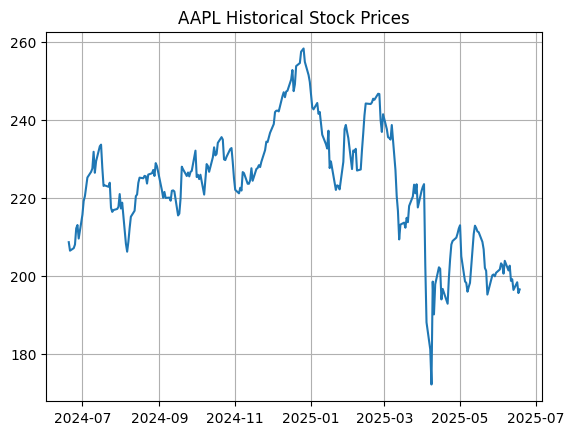

In [36]:
fig, ax = plt.subplots()

ax.plot(hist.index, hist["Close"])
ax.set_title(f"{ticker} Historical Stock Prices")
ax.set_ylabel = "Price (USD)"
ax.set_xlabel = "Date"
ax.grid(True)


In [69]:
strike_price = float(210)
risk_free_rates = FED_RATES[5]
expire_date = datetime.date(2025,6,20)
num_steps = 100
opt_type = 'Call'
exercise_type = "European"
hist["Option Value"] = np.nan
count = 0
dates = hist.index
for price in hist["Close"]:
    opt_tree, stock_tree = binomial_model(price, strike_price, rate, time, num_steps, volatility, option_type=opt_type,exercise_type="American")
    option_value = opt_tree[0,0]
    date = dates[count]
    hist.at[date,"Option Value"] = option_value
    count += 1


print(hist["Option Value"])

Date
2024-06-20 00:00:00-04:00    1.834712
2024-06-21 00:00:00-04:00    1.059411
2024-06-24 00:00:00-04:00    1.265178
2024-06-25 00:00:00-04:00    1.596501
2024-06-26 00:00:00-04:00    3.761076
                               ...   
2025-06-12 00:00:00-04:00    0.077551
2025-06-13 00:00:00-04:00    0.020455
2025-06-16 00:00:00-04:00    0.053986
2025-06-17 00:00:00-04:00    0.013088
2025-06-18 00:00:00-04:00    0.021918
Name: Option Value, Length: 250, dtype: float64


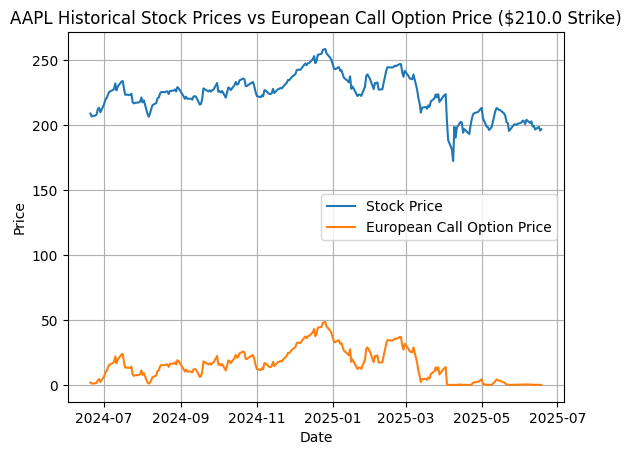

In [70]:
fig, ax = plt.subplots()
ax.plot(hist.index,  hist["Close"],  label="Stock Price")       
ax.plot(hist.index, hist["Option Value"], label=f"{exercise_type} {opt_type} Option Price")      
ax.set_title(f"{ticker} Historical Stock Prices vs {exercise_type} {opt_type} Option Price (${strike_price} Strike)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.legend()                                               
plt.show()

In [75]:
opt_tree, stock_tree = binomial_model(100, 105, 0.06, 252, 100, 0.3, option_type="Put")
print(opt_tree[0,0])


11.311914021842808
